## ROC Curves and AUC

Sandbox to experiment with ROC Curves and AUC.

Objectives:
- Use ROC Curve to determine an optimal output threshold for classification
- Implement output threshold as a hyperparameter for classifier models
- Compare ROC Curves to Precision-Recall Curves

Resources:
- https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077
- https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve.ipynb
- https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [341]:
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


### Generate Dataset

To start experimenting with ROC techniques, let's create a synthetic dataset for two classes.

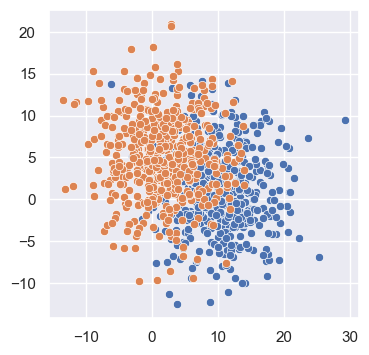

In [342]:
# Parameters
np.random.seed(42)
scale = 5
size = 500

# Generate class 1
class1_x = np.random.normal(loc=10, scale=scale, size=size)
class1_y = np.random.normal(loc=1, scale=scale, size=size)
# Generate class 2
class2_x = np.random.normal(loc=1, scale=scale, size=size)
class2_y = np.random.normal(loc=5, scale=scale, size=size)

# Inspect overlap
plt.figure(figsize=(4, 4))
sns.scatterplot(x=class1_x, y=class1_y)
sns.scatterplot(x=class2_x, y=class2_y)
plt.show()


In [343]:
# Create dataframe
df_class1 = pd.DataFrame()
df_class1['x'] = class1_x
df_class1['y'] = class1_y
df_class1['class'] = 0

df_class2 = pd.DataFrame()
df_class2['x'] = class2_x
df_class2['y'] = class2_y
df_class2['class'] = 1

df = pd.concat([df_class1, df_class2], ignore_index=True)


In [344]:
# Get dependent and independent variables
X = df.drop(columns=['class'])
y = df['class']


While the approach above works well for generating synthetic data from scratch, a simpler alternative approach exists with much less code.

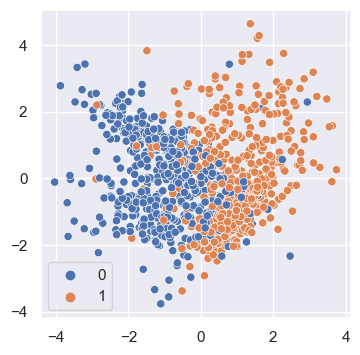

In [345]:
# Alternative, simpler approach to generating synthetic data.
# Change random_state for wildly different groupings
n_samples = 1000
X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                           n_clusters_per_class=2, weights=None, flip_y=0.05, random_state=1)

# Inspect
plt.figure(figsize=(4, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.show()


### Fit Classifier Model

Let's fit a simple classifier model to the data.

In [346]:
# Test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


              precision    recall  f1-score   support

           0       0.80      0.81      0.81        85
           1       0.86      0.85      0.86       115

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.84      0.83      0.84       200



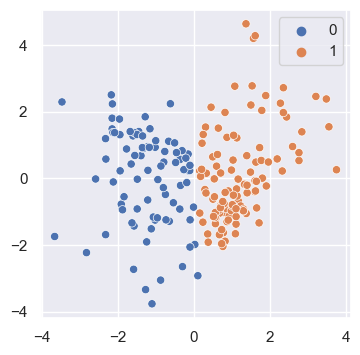

In [347]:
# Fit
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(metrics.classification_report(y_test, y_pred))

# Inspect
plt.figure(figsize=(4, 4))
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred)
plt.show()


### ROC Curve

We're now ready to generate the ROC Curve and AUC.

In [348]:
# Get probabilities for each class
y_proba = model.predict_proba(X_test)
y_proba[:5]


array([[0.90684503, 0.09315497],
       [0.4869693 , 0.5130307 ],
       [0.32497312, 0.67502688],
       [0.23945218, 0.76054782],
       [0.05238567, 0.94761433]])

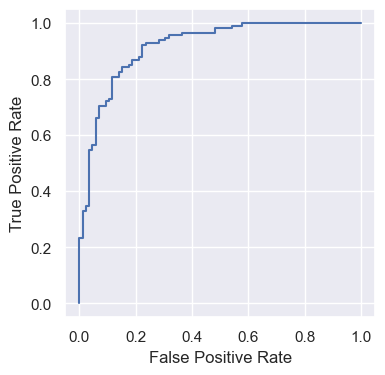

In [349]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1], pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
roc_display.figure_.set_size_inches(4, 4)


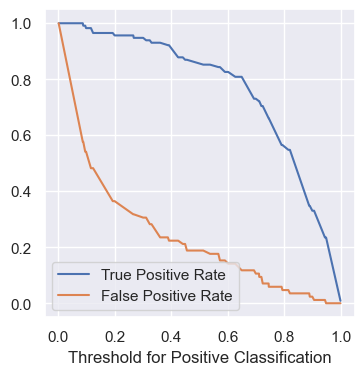

In [350]:
# Explore thresholds
plt.figure(figsize=(4, 4))
plt.plot(thresholds[1:], tpr[1:], label='True Positive Rate')
plt.plot(thresholds[1:], fpr[1:], label='False Positive Rate')
plt.xlabel('Threshold for Positive Classification')
plt.legend()
plt.show()


The True Positive Rate is known as Sensitivity and the inverse of the False Positive Rate is Specificity.
- True Positive Rate (Sensitivity) = $TP \over TP + FN$
- False Positive Rate = $FP \over TP + FN$
- True Negative Rate (Specificity) = $TN \over FP + TN$

In [351]:
# AUC
print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}")


AUC: 0.8320


### Determine Best Threshold

Let's look at one way to compute the "best" threshold that provides an optimal balance between false positive and true positive rates. The technique used here is [Youden's J statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic).

In [352]:
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print(f'Best Threshold: {best_thresh:.3f}')


Best Threshold: 0.392


### Tuning the Model's Decision Threshold

After determining an optimal classification threshold, the next step is to implement that decision threshold into the prediction model. Tuning the decision threshold is often referred to as *threshold-moving*, *threshold-tuning*, or even *thresholding*. This technique is also often used with imbalanced datasets.

To make the decision threshold a hyperparameter, we'll create a custom transformer.

In [353]:
class ClassifierThreshold(BaseEstimator, RegressorMixin):
    """Classifier with selectable threshold level"""

    def __init__(self, classifier, threshold):
        self.classifier = classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.classifier.predict_proba(X)

    def predict(self, X):
        proba = self.classifier.predict_proba(X)[:, 1]
        y_pred = np.where(proba > self.threshold, 1, 0)
        return y_pred


In [354]:
for threshold in [0.5, best_thresh]:
    print(f'Decision Threshold: {threshold:.3f}')

    # Fit custom classifier model
    model = ClassifierThreshold(LogisticRegression(), threshold=threshold)
    model.fit(X_train, y_train)

    # Evaluate
    print(metrics.classification_report(y_test, model.predict(X_test)))


Decision Threshold: 0.500
              precision    recall  f1-score   support

           0       0.80      0.81      0.81        85
           1       0.86      0.85      0.86       115

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.84      0.83      0.84       200

Decision Threshold: 0.392
              precision    recall  f1-score   support

           0       0.87      0.78      0.82        85
           1       0.85      0.91      0.88       115

    accuracy                           0.85       200
   macro avg       0.86      0.84      0.85       200
weighted avg       0.86      0.85      0.85       200



By updating the model to use the more optimal threshold level, the overall accuracy on the test data increased by 2%. If the classes were more imbalanced, the improvement is expected to be even greater.

### Imbalanced Classes

Let's repeat the theshold-tuning procedure again but for a dataset with imbalanced classes to really see the power of threshold-tuning.

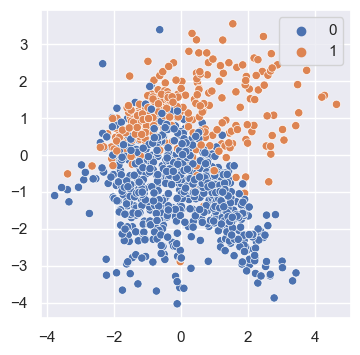

In [355]:
# 70% Class 0, 30% Class 1
X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                           n_clusters_per_class=2, weights=[0.70], flip_y=0, random_state=1)

# Inspect
plt.figure(figsize=(4, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.show()


In [356]:
# Test-train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit custom classifier model
model = ClassifierThreshold(LogisticRegression(), threshold=0.5)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.91      0.91       149
           1       0.73      0.75      0.74        51

    accuracy                           0.86       200
   macro avg       0.82      0.83      0.82       200
weighted avg       0.87      0.86      0.87       200



In [357]:
def roc_threshold(model, X, y):
    """Plot ROC Curve and return the optimal threshold that balances
    false positive and true positive rates"""

    # Get probabilities for each class
    y_proba = model.predict_proba(X)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y, y_proba[:, 1], pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(4, 4)

    J = tpr - fpr
    ix = argmax(J)
    best_thresh = thresholds[ix]
    print(f'Best Threshold: {best_thresh:.3f}')

    return best_thresh


Best Threshold: 0.368


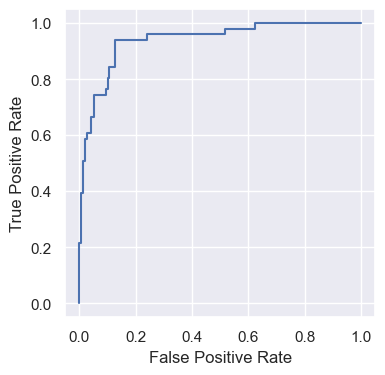

In [358]:
best_thresh_tpfp = roc_threshold(model, X_test, y_test)


In [359]:
for threshold in [0.5, best_thresh_tpfp]:
    print(f'Decision Threshold: {threshold:.3f}')

    # Fit custom classifier model
    model = ClassifierThreshold(LogisticRegression(), threshold=threshold)
    model.fit(X_train, y_train)

    # Evaluate
    print(metrics.classification_report(y_test, model.predict(X_test)))


Decision Threshold: 0.500
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       149
           1       0.73      0.75      0.74        51

    accuracy                           0.86       200
   macro avg       0.82      0.83      0.82       200
weighted avg       0.87      0.86      0.87       200

Decision Threshold: 0.368
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       149
           1       0.71      0.92      0.80        51

    accuracy                           0.89       200
   macro avg       0.84      0.90      0.86       200
weighted avg       0.90      0.89      0.89       200



Choosing an optimal decision threshold improved overall accuracy by 3%.

### Precision-Recall Curve

It's worth looking at the precision-recall curve to highlight the differences. Unlike the ROC curve, the precision-recall curve is focused on the classifier model's performance on the positive class only.

Precision is also known as the Positive Predictive Value (PPV) and Recall is the same as Sensitivity.

- Precision = $TP \over TP + FP$
- Recall (Sensitivity) = $TP \over TP + FN$

In [360]:
# Fit custom classifier model
model = ClassifierThreshold(LogisticRegression(), threshold=0.5)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)


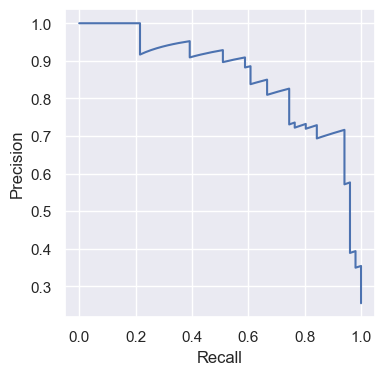

In [361]:
precision, recall, thresholds = precision_recall_curve(
    y_test, y_proba[:, 1], pos_label=1)

plt.figure(figsize=(4, 4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


In [362]:
score = metrics.f1_score(y_test, y_pred)
print(f'F1-Score: {score:.3f}')


F1-Score: 0.738


Which threshold produces the best F1-score, or the best balance between precision and recall?

In [363]:
# Test range
thresholds = np.arange(0, 1, 0.01)

scores = []
for t in thresholds:
    model = ClassifierThreshold(LogisticRegression(), threshold=t)
    model.fit(X_train, y_train)
    scores.append(metrics.f1_score(y_test, model.predict(X_test)))

# Best threshold
ix = argmax(scores)
print(f'Threshold={thresholds[ix]:.3f}, F1-Score={scores[ix]:.3f}')


Threshold=0.340, F1-Score=0.814


The optimal threshold here increases the F1-Score from 0.738 to 0.814.

A more efficient solution exists where model fit and predict is only run once:

In [364]:
# Test range
thresholds = np.arange(0, 1, 0.01)

model = ClassifierThreshold(LogisticRegression(), threshold=0.5)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]

scores = []
for t in thresholds:
    y_pred = np.where(y_proba > t, 1, 0)
    scores.append(metrics.f1_score(y_test, y_pred))

# Best threshold
ix = argmax(scores)
print(f'Threshold={thresholds[ix]:.3f}, F1-Score={scores[ix]:.3f}')
best_thresh_pr = thresholds[ix]


Threshold=0.340, F1-Score=0.814


In [365]:
for threshold in [0.5, best_thresh_tpfp, best_thresh_pr]:
    print(f'Decision Threshold: {threshold:.3f}')

    # Fit custom classifier model
    model = ClassifierThreshold(LogisticRegression(), threshold=threshold)
    model.fit(X_train, y_train)

    # Evaluate
    print(metrics.classification_report(y_test, model.predict(X_test)))


Decision Threshold: 0.500
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       149
           1       0.73      0.75      0.74        51

    accuracy                           0.86       200
   macro avg       0.82      0.83      0.82       200
weighted avg       0.87      0.86      0.87       200

Decision Threshold: 0.368
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       149
           1       0.71      0.92      0.80        51

    accuracy                           0.89       200
   macro avg       0.84      0.90      0.86       200
weighted avg       0.90      0.89      0.89       200

Decision Threshold: 0.340
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       149
           1       0.72      0.94      0.81        51

    accuracy                           0.89       200
   macro avg       0.85      0.91      0.87       

Note how the optimal decision threshold here for balancing precision and recall is different from the optimal for balancing true positive and false positive rates from earlier.